## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [41]:
#import numpy as np
#import pandas as pd

#reviews = pd.read_csv('reviews.txt', header=None)
#labels = pd.read_csv('labels.txt', header=None)
#Y = (labels=='positive').astype(np.int_)

#print(type(reviews))
#print(reviews.head())

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(d)** Test your sentiment-classifier on the test set.

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [42]:
# Library imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Declare 'shared' variables:
max_features_bag_of_words = 10000
random_state = 946

### a)
Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

This approach is pretty standard and self-explanatory.

In [43]:
# Preparing the data:
reviews = pd.read_csv('reviews.txt', header=None)[0]
labels = pd.read_csv('labels.txt', header=None)[0]
y = (labels == 'positive').astype(np.int_)

# Split the data into training+validation and test sets.
# 15% of the data for final testing.
X_train_validation, X_test, y_train_validation, y_test = train_test_split(reviews, y, test_size=0.15, random_state=random_state)

# Split the data into training and validation sets
# 15% for validation (of the 85%)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.15, random_state=random_state)

print("No. of training examples:", len(X_train))
print("No. of validation examples:", len(X_validation))
print("No. of test examples:", len(X_test))

No. of training examples: 18062
No. of validation examples: 3188
No. of test examples: 3750


Using CountVectorizer to create a Bag-of-Words, containing only the 10,000 most frequent words.

In [44]:
bagOfWords_vector = CountVectorizer(max_features=max_features_bag_of_words)
X_train_bagOfWords = bagOfWords_vector.fit(X_train)
X_validation_bagOfWords = bagOfWords_vector.transform(X_validation)
X_test_bagOfWords = bagOfWords_vector.transform(X_test)

## b)
Explore the representation of the reviews. How is a single word represented? How about a whole review?

Let's print parts of the generated bag-of-words vector and see how single words are represented:


Original review:
what happened   doubt  had so much potential to be a brilliant film  but instead it faltered with a dragging simplistic plot line which made me want to stop watching . the only thing the film had going for it was the brilliance of meryl streep  who no doubt deserved the oscar  nomination . though it was not one of her best performances  she still gave a solid and truthful character to us which blossomed through the screen .  br    br   however  not even the brilliance of a screen legend could save this film from going down hill . from the boring start  which had no power or punch  to the less than convincing ending  the film was truly a disappointment  especially since it provided so much potential through its promotion and trailers . it was obvious the director had trouble with the simplicity of the plot and he ended up with a boring film  which dragged on for too long  with too much talk and not enough action .  br    br   furthermore  the other oscar  nominations we

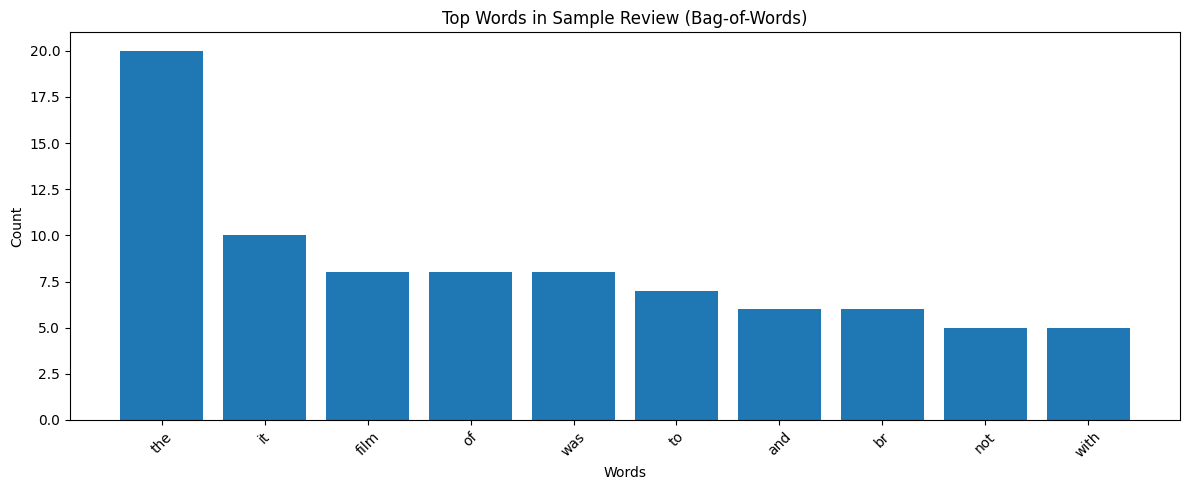

The word 'the' is in the vocabulary at index 8956
Full vector (first 100 values):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
Number of words with non-zero frequency: 160
Total vector size: 10000


In [45]:
# Let's take a look at the first review in the training data and see how this is represented.
sample_review = X_train.iloc[0]
sample_vector = bagOfWords_vector.transform([sample_review])

# Convert to dense format and get feature names
dense_vector = sample_vector.toarray()[0]
feature_names = bagOfWords_vector.get_feature_names_out()

# Map non-zero entries to their words and counts
word_counts = {feature_names[i]: dense_vector[i] for i in range(len(dense_vector)) if dense_vector[i] > 0}

# Sort and visualize top words
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

print(f"Original review:\n{sample_review}\n")
print("Bag-of-Words representation (non-zero counts):")
for word, count in sorted_word_counts.items():
    print(f"{word}: {count}")

top_n = 10
plt.figure(figsize=(12, 5))
plt.bar(list(sorted_word_counts.keys())[:top_n], list(sorted_word_counts.values())[:top_n])
plt.xticks(rotation=45)
plt.title("Top Words in Sample Review (Bag-of-Words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Now let's take a look at how single words are represented.
# I choose the word 'the' to investigate, as this appears most times in the review.
word = "the"

# I can now get the index of this word:
word_index = bagOfWords_vector.vocabulary_.get(word)
print(f"The word '{word}' is in the vocabulary at index {word_index}")

# Let's see how the review is actually represented (only first 50 values shown)
print("Full vector (first 100 values):")
print(dense_vector[:100])

# Let's see how many non-zero values exist:
non_zero_count = np.count_nonzero(dense_vector)
print(f"Number of words with non-zero frequency: {non_zero_count}")
print(f"Total vector size: {len(dense_vector)}")

**Whole Review:** We see that the whole review is represented by a number of individual words. The bag of words, when fitted, stores each words in a vector with a weight assigned to each word corresponding to how many times the individual word appears in the review/text. It is worth noting that the review is only displayed using the top words that were fit into the primary bag of words trained vector (i.e. 10.000 top words). That causes 'holes' to appear, when reading the review. In essence, the bag of words vector represents a 10.000 dimensional array, where most values are zero (sparse) and if a word appears in the review, it's index will have a non-zero count.

The vectorized review is displayed as [0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 ... etc], where each word in the bag of words has a index position and when a word in the actual review matches one of these words, its count is increased by one.

Each word is represented by its index position in the vectorized word array (i.e. we find the word 'the' at index 8958 and by reading that index we can get the count (how many times this word appears in the review)).


### c)
Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy.

I'll be using the default configuration from table 11-2 in the Book (Hands-On Machine Learning ...)

        Initialization          : He initialization
        Activation function     : ELU
        Normalization           : Batch Normalization
        Regularization          : Dropout
        Optimizer               : Adam
        Learning rate schedule  : None

In [46]:
# Transform the training, validation, and test sets using the CountVectorizer
X_train_vect = bagOfWords_vector.transform(X_train).toarray()
X_validation_vect = bagOfWords_vector.transform(X_validation).toarray()
X_test_vect = bagOfWords_vector.transform(X_test).toarray()

model = tf.keras.Sequential([
    # This is the first 'hidden' layer with 128 perceptrons.
    layers.Dense(128, kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    layers.Dropout(0.2),

    # This is the output layer:
    layers.Dense(1, activation="sigmoid")
])

# Compile the model for training, using the recommended default configuration:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)


# Here I train (fit) the actual model. It returns a History object that can be used for model evaluation:
history = model.fit(
    X_train_vect, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_validation_vect, y_validation),
    verbose=2
)

# Now I evaluate the model for accuracy against the validation data
val_loss, val_acc = model.evaluate(X_validation_vect, y_validation, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

# Let's compare this to the external test data:
test_loss, test_accuracy = model.evaluate(X_test_vect, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Finally, let's generate a report:
y_val_pred = (model.predict(X_test_vect) > 0.5).astype(int)
print(classification_report(y_test, y_val_pred))

Epoch 1/30
283/283 - 4s - 13ms/step - accuracy: 0.8458 - loss: 0.3610 - val_accuracy: 0.8839 - val_loss: 0.2794
Epoch 2/30
283/283 - 2s - 8ms/step - accuracy: 0.9227 - loss: 0.1957 - val_accuracy: 0.8855 - val_loss: 0.2877
Epoch 3/30
283/283 - 2s - 8ms/step - accuracy: 0.9425 - loss: 0.1452 - val_accuracy: 0.8723 - val_loss: 0.3384
Epoch 4/30
283/283 - 2s - 8ms/step - accuracy: 0.9533 - loss: 0.1191 - val_accuracy: 0.8670 - val_loss: 0.3652
Epoch 5/30
283/283 - 2s - 8ms/step - accuracy: 0.9663 - loss: 0.0894 - val_accuracy: 0.8683 - val_loss: 0.4150
Epoch 6/30
283/283 - 2s - 8ms/step - accuracy: 0.9694 - loss: 0.0829 - val_accuracy: 0.8711 - val_loss: 0.4395
Epoch 7/30
283/283 - 2s - 8ms/step - accuracy: 0.9758 - loss: 0.0665 - val_accuracy: 0.8692 - val_loss: 0.4963
Epoch 8/30
283/283 - 2s - 8ms/step - accuracy: 0.9748 - loss: 0.0659 - val_accuracy: 0.8654 - val_loss: 0.5299
Epoch 9/30
283/283 - 2s - 8ms/step - accuracy: 0.9771 - loss: 0.0588 - val_accuracy: 0.8582 - val_loss: 0.5622


### d)
Test your sentiment-classifier on the test set.

The sentiment-classifier was tested on the test set above -> As well as tested on the validation set. See conclusion below.

**Conclusion:** The report demonstrates that the trained model has an overall accuracy of 86% with consistent results between accuracy, macro avg and weighed avg. Comparing to the final test accuracy at 85.6% with the final validation accuracy at 85.95% these values seem to correlate nicely, suggesting a good fit. It could be interesting to see what happens if I reduce the overfitting (decrease the val_loss in the epochs) and see how this translates to model accuracy on validation and test data.

Furthermore, let's visualize a few of the classifications of the reviews for better visual overview:

In [47]:
test_sentences = [
    reviews[0],
    reviews[17],
    reviews[34],
    reviews[51],
    reviews[68],
    reviews[85]
]

test_vector = bagOfWords_vector.transform(test_sentences)
test_predictions = model.predict(test_vector)

counter = 0
for sentence, prob in zip(test_sentences, test_predictions):
    label = "Positive" if prob >= 0.5 else "Negative"
    print(f"Sentence: \"{sentence}\"\n → Predicted: {label} ({prob[0]:.4f}). Should be: {labels[counter]}\n")
    counter += 17

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Sentence: "bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   "
 → Predicted: Negative (0.3889). Should be: positive

Sentence: "this film is mediocre at best . angie harmon is as 

### e)
Use the classifier to classify a few sentences you write yourselves.

I'll be testing the classification on these custom sentences:
1. "Legendary movie. Orlando bloom nailed his role as Legolas and Peter Jackson really knows how to deliver a faithful story. Not much can be improved, and this movie is certain to become a classic".
2. "I regret wasting 2 hours of my life seeing this woke garbage."
3. "The movie was neither great nor horrible. Okay entertainment, but only if you're very bored".

In [48]:
custom_sentences = [
    "Legendary movie. Orlando bloom nailed his role as Legolas and Peter Jackson really knows how to deliver a faithful story. Not much can be improved, and this movie is certain to become a classic",
    "I regret wasting 2 hours of my life seeing this woke garbage.",
    "The movie was neither great nor horrible. Okay entertainment, but only if you're very bored"
]

custom_vector = bagOfWords_vector.transform(custom_sentences)
custom_predictions = model.predict(custom_vector)

for sentence, prob in zip(custom_sentences, custom_predictions):
    label = "Positive" if prob >= 0.5 else "Negative"
    print(f"Sentence: \"{sentence}\"\n → Predicted: {label} ({prob[0]:.4f}).\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Sentence: "Legendary movie. Orlando bloom nailed his role as Legolas and Peter Jackson really knows how to deliver a faithful story. Not much can be improved, and this movie is certain to become a classic"
 → Predicted: Positive (0.9996).

Sentence: "I regret wasting 2 hours of my life seeing this woke garbage."
 → Predicted: Negative (0.0262).

Sentence: "The movie was neither great nor horrible. Okay entertainment, but only if you're very bored"
 → Predicted: Negative (0.0010).



## Conclusions:
The overall training of the neural network and predictions seem faily accurate, albeit not entirely. The bag of words principle works surprisingly well, combined with Artificial Neural Networks (Such as the sequential classifier used). I wonder if using more than 1 hidden layer might improve accuracy without introducing more bias - but that is something that must be tested separately. The trained model still struggles with the reviews that are neither good or bad (the neutral ones), as displayed in my custom_sentences, where I wrote a good review, a bad review and a neutral review.

Another point I'm wondering, is it I could improve bag of words performance by filtering out common words such as 'the', 'or', 'and', etc. as these are neither positively or negatively loaded. This could provide more room for more relevant words. Or I could simply increase the number of features. This is also something that must be tested separately.